In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

Exploratory Data Analysis (EDA)

In [3]:
# Importing store data
df_revenue = pd.read_csv('fake_clinic_data_extract_test (1).csv')
df_revenue.head()

,appointment_date,clinic_name,patient_id,practitioner_id,appointment_duration_min,revenues_from_appointment
0,2021-12-30,clinic_2,70172,1030,30,98.13
1,2021-12-29,clinic_1,53371,756,15,65.13
2,2021-12-29,clinic_2,69545,1030,30,105.18
3,2021-12-27,clinic_1,43859,756,30,58.11
4,2021-12-23,clinic_1,69303,756,30,119.00


In [4]:
df_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4071 entries, 0 to 4070
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   appointment_date           4071 non-null   object 
 1   clinic_name                4071 non-null   object 
 2   patient_id                 4071 non-null   int64  
 3   practitioner_id            4071 non-null   int64  
 4   appointment_duration_min   4071 non-null   int64  
 5   revenues_from_appointment  3696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 191.0+ KB


In [5]:
#string to date format
df_revenue['Month'] = pd.to_datetime(df_revenue['appointment_date'],infer_datetime_format=True)
df_revenue.head(5)

,appointment_date,clinic_name,patient_id,practitioner_id,appointment_duration_min,revenues_from_appointment,Month
0,2021-12-30,clinic_2,70172,1030,30,98.13,2021-12-30
1,2021-12-29,clinic_1,53371,756,15,65.13,2021-12-29
2,2021-12-29,clinic_2,69545,1030,30,105.18,2021-12-29
3,2021-12-27,clinic_1,43859,756,30,58.11,2021-12-27
4,2021-12-23,clinic_1,69303,756,30,119.00,2021-12-23


In [6]:
df_revenue_1 = df_revenue.copy() #Made a copy just in case I need it later

In [7]:
df_revenue.isnull().sum() #check for null values (375 present in the dataset)

appointment_date               0
clinic_name                    0
patient_id                     0
practitioner_id                0
appointment_duration_min       0
revenues_from_appointment    375
Month                          0
dtype: int64

In [8]:
df_revenue.shape

(4071, 7)

In [9]:
(375/4071)*100 #check for percentage of null values i.e. 9.2% in this case which is not very high, but I will replace them

9.211495946941783

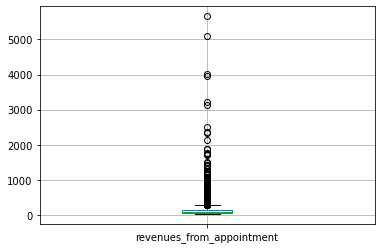

In [10]:
#Considering the boxplot here, it gives a clear picture that majority of the data lies below 1000, and there are quite some outliers

df_revenue.boxplot(['revenues_from_appointment']); 

In [11]:
#Replaced null values with median since the outliers cannot affect the data distribution
df_revenue.fillna(df_revenue['revenues_from_appointment'].median(), inplace=True)
print(df_revenue)

     appointment_date clinic_name  patient_id  practitioner_id  \
0          2021-12-30    clinic_2       70172             1030   
1          2021-12-29    clinic_1       53371              756   
2          2021-12-29    clinic_2       69545             1030   
3          2021-12-27    clinic_1       43859              756   
4          2021-12-23    clinic_1       69303              756   
...               ...         ...         ...              ...   
4066       2021-08-19    clinic_1       44907              755   
4067       2021-09-02    clinic_1       45056              757   
4068       2021-08-19    clinic_1       44919              757   
4069       2021-07-22    clinic_1       45055              755   
4070       2021-07-22    clinic_1       44912              755   

      appointment_duration_min  revenues_from_appointment      Month  
0                           30                      98.13 2021-12-30  
1                           15                      65.13 2021-12

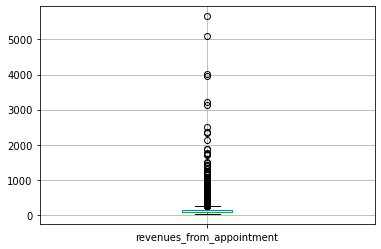

In [12]:
df_revenue.boxplot(['revenues_from_appointment']); 

In [13]:
df_revenue.isnull().sum() # No null values now after replacement with median

appointment_date             0
clinic_name                  0
patient_id                   0
practitioner_id              0
appointment_duration_min     0
revenues_from_appointment    0
Month                        0
dtype: int64

In [14]:
#groupby date and sum the revenue values to get unique dates 
#and sum of all revenue values for that particular date
df_revenue = df_revenue.groupby('Month').revenues_from_appointment.sum().reset_index()

In [15]:
df_revenue.head() #aggregating all the dates with the sum of the revenues

,Month,revenues_from_appointment
0,2021-06-28,1622.54
1,2021-06-29,1052.20
2,2021-06-30,891.24
3,2021-07-01,443.66
4,2021-07-02,443.55


In [19]:
df_revenue_2 = df_revenue.copy()

In [20]:
df_revenue_2.head()

,Month,revenues_from_appointment
0,2021-06-28,1622.54
1,2021-06-29,1052.20
2,2021-06-30,891.24
3,2021-07-01,443.66
4,2021-07-02,443.55


In [16]:
df_revenue = df_revenue.set_index(['Month']) #Month is set as the index
df_revenue.head(5)

,revenues_from_appointment
Month,
2021-06-28,1622.54
2021-06-29,1052.20
2021-06-30,891.24
2021-07-01,443.66
2021-07-02,443.55


In [17]:
df_revenue['revenues_from_appointment'].describe()

count      132.000000
mean      4800.985000
std       2470.315604
min        443.550000
25%       3008.662500
50%       4550.595000
75%       6022.815000
max      12699.030000
Name: revenues_from_appointment, dtype: float64

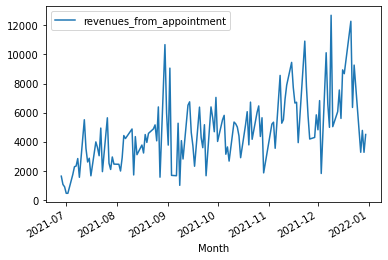

In [18]:
df_revenue.plot();

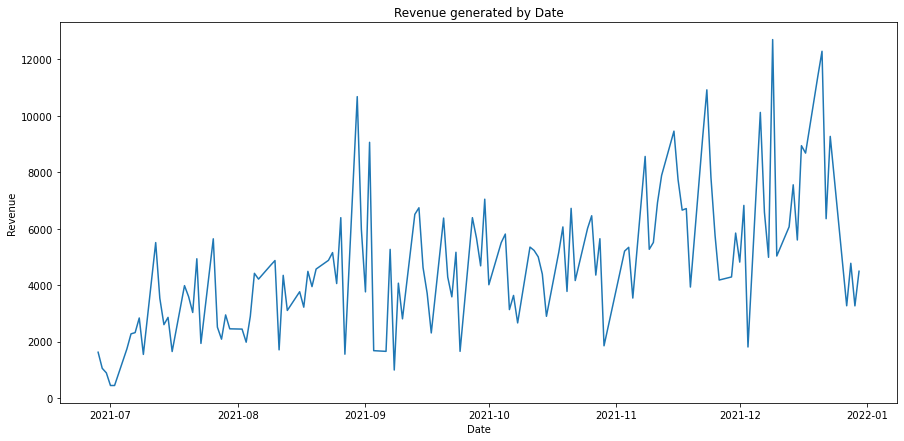

In [19]:
plt.figure(figsize=(15,7))
plt.title("Revenue generated by Date")
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.plot(df_revenue['revenues_from_appointment'])
plt.show()

In [20]:
# ADF stationarity test
# Returns: {Test statistic, P-value, Num lags used, {Critical values}, Estmation of maximized information criteria}


print('Results of Dickey Fuller Test:')
dftest = adfuller(df_revenue['revenues_from_appointment'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -1.961847
p-value                          0.303548
#Lags Used                       9.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


The p-value in this case is > 0.05 which suggests that the data is non-stationary in this case and 
we have to convert into stationary form below

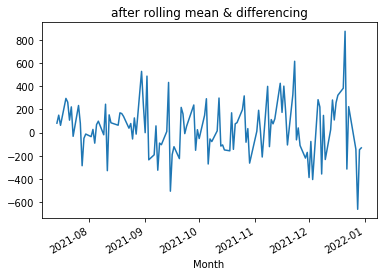

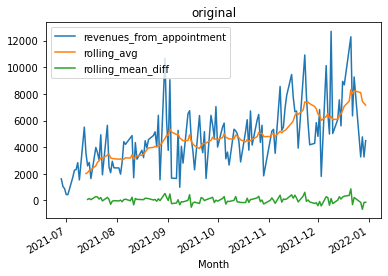

In [21]:
#Appling the rolling mean differencing to remove non-stationarity



df_revenue["rolling_avg"] = df_revenue["revenues_from_appointment"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
#df_revenue["rolling_std"] = df_revenue["revenues_from_appointment"].rolling(window=12).std()
df_revenue['rolling_mean_diff'] = df_revenue["rolling_avg"] - df_revenue["rolling_avg"].shift()
ax1 = plt.subplot()
df_revenue['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
df_revenue.plot(title='original');

In [22]:
dftest = adfuller(df_revenue['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t",key, ": ", val)

#p-value < 0.05 which implies data has become stationary after applying rolling mean differencing above

1. ADF :  -5.318615611851164
2. P-Value :  5.009848755360621e-06
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 107
5. Critical Values :
	 1% :  -3.492995948509562
	 5% :  -2.888954648057252
	 10% :  -2.58139291903223


C:\Users\ABHIRO~1\AppData\Local\Temp/ipykernel_8364/529474947.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition= seasonal_decompose(df_revenue["revenues_from_appointment"], model = 'additive',freq=52)


Text(0.5, 1.0, 'Decomposition Plots')

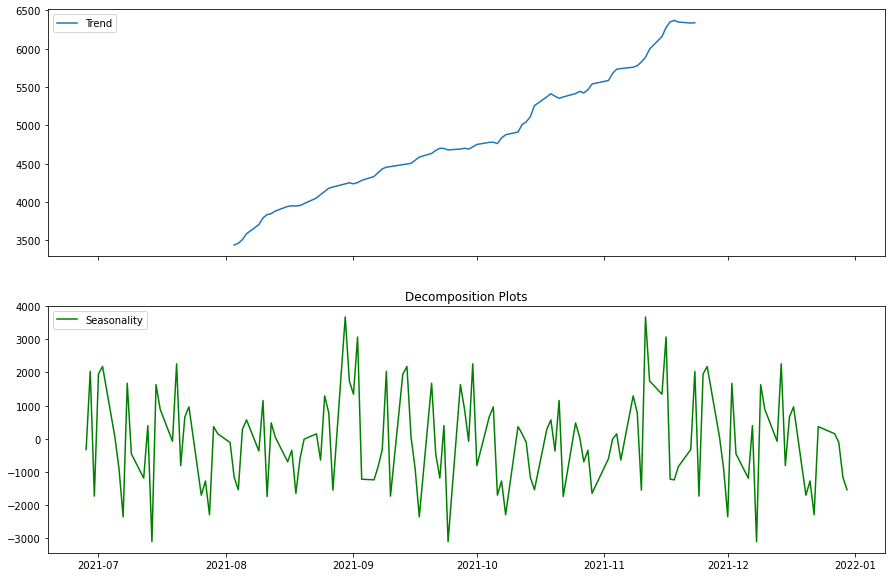

In [23]:
# Plotting seasonality and trend
from statsmodels.tsa.seasonal import seasonal_decompose

fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)
decomposition= seasonal_decompose(df_revenue["revenues_from_appointment"], model = 'additive',freq=52)
estimated_trend = decomposition.trend
estimated_seasonal = decomposition.seasonal
estimated_residual = decomposition.resid
axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
axes[1].legend(loc='upper left');
    
axes[0].plot(estimated_trend, label='Trend')
axes[0].legend(loc='upper left');
plt.title('Decomposition Plots')


There is an upward trend, but since the data size is very less, we cannot derive significant seasonality from the graph above

We will start with various modeling techniques like ARIMA, SARIMA, and SARIMAX to find the forecasted
data and also we use performance metrics such as RMSE (Root Mean Square Error)

Model 1: Autoregressive Integrated Moving Average (ARIMA)

In [24]:
import itertools

In [25]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Determing p,d,q combinations with AIC scores. 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_revenue['revenues_from_appointment'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except ValueWarning:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2626.095620270154
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2346.8403454661616
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2231.558240243928
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1994.2384790453364
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2250.42202784401
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2209.255277509094
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2015.5228015138794
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1996.0478106017733
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2548.2204141117422
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2257.945579586744
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2214.373680829137
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1978.073737923551
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2250.1858148975202
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2191.3445164127993
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2017.9476359710081
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1980.0620384199
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2430.3795369445775
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2216.9241227087637
ARI

In [28]:
# Fitting the data to ARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(df_revenue['revenues_from_appointment'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_sarima = model_sarima.fit()
print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0334      0.094      0.357      0.721      -0.150       0.217
ma.L1         -1.0028      0.399     -2.514      0.012      -1.785      -0.221
ma.S.L12      -1.1002      0.184     -5.969      0.000      -1.461      -0.739
sigma2      4.136e+06   2.13e+06      1.938      0.053   -4.58e+04    8.32e+06


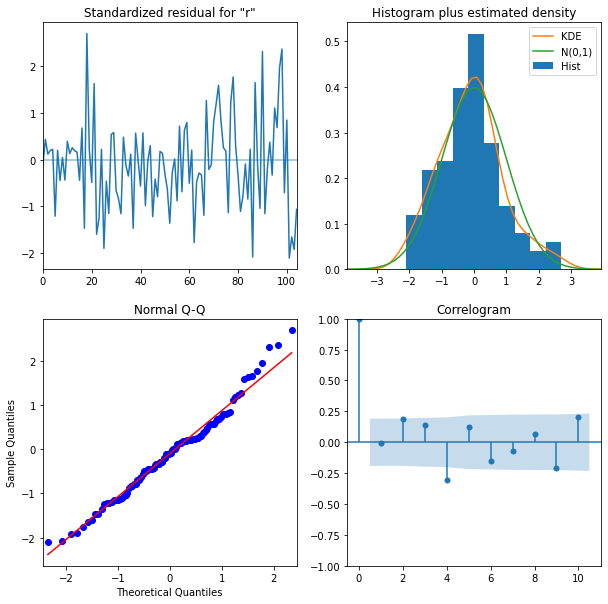

In [29]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, r2_score

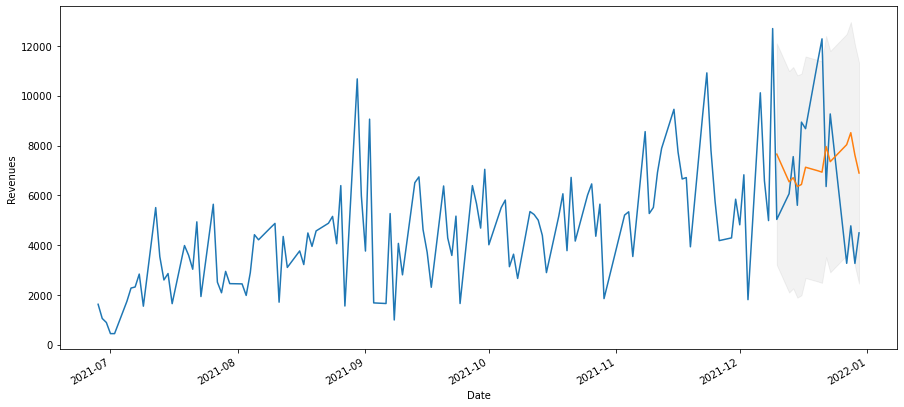

In [31]:
# Model Prediction
# Predictions are performed for the 10th Dec' 2021 onwards of the train data.
pred = results_sarima.get_prediction(start=pd.to_datetime('2021-12-10'), dynamic = False)
# Get confidence intervals of forecasts
pred_ci = pred.conf_int()
ax = df_revenue['revenues_from_appointment']["2021-06-28":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)
ax.set_xlabel("Date")
ax.set_ylabel("Revenues")
plt.legend
plt.show()
train_arima_forecasted = pred.predicted_mean
train_arima_truth = df_revenue['revenues_from_appointment']["2021-12-10":]


In [32]:
# Calculating the root mean squared error
rms_arima = np.sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

Root Mean Squared Error:  3082.8136757360503


In [33]:
from sklearn.metrics import mean_absolute_error
# Calculating the mean absolute error
mae_arima = mean_absolute_error(train_arima_truth, train_arima_forecasted)
print("Mean Absolute Error: ", mae_arima)

Mean Absolute Error:  2666.2297379275046


In [80]:
print(train_arima_forecasted)

Month
2021-12-10    7654.343306
2021-12-13    6541.869569
2021-12-14    6707.237877
2021-12-15    6353.824020
2021-12-16    6435.036207
2021-12-17    7127.324677
2021-12-20    6985.522809
2021-12-21    6930.301503
2021-12-22    7958.006172
2021-12-23    7351.072917
2021-12-27    8034.881063
2021-12-28    8515.730401
2021-12-29    7613.617436
2021-12-30    6895.300354
Name: predicted_mean, dtype: float64


In [81]:
print(train_arima_truth)

Month
2021-12-10     5030.87
2021-12-13     6065.43
2021-12-14     7554.30
2021-12-15     5598.49
2021-12-16     8939.87
2021-12-17     8676.86
2021-12-20    11415.65
2021-12-21    12285.30
2021-12-22     6353.01
2021-12-23     9269.02
2021-12-27     3267.80
2021-12-28     4773.41
2021-12-29     3264.74
2021-12-30     4491.11
Name: revenues_from_appointment, dtype: float64


The forecasted values does not correspond well with the real values of the data which signifies that
the ARIMA algorithm does not do a good job in predicting the results.

Model 2: Seasonal ARIMA (SARIMA)

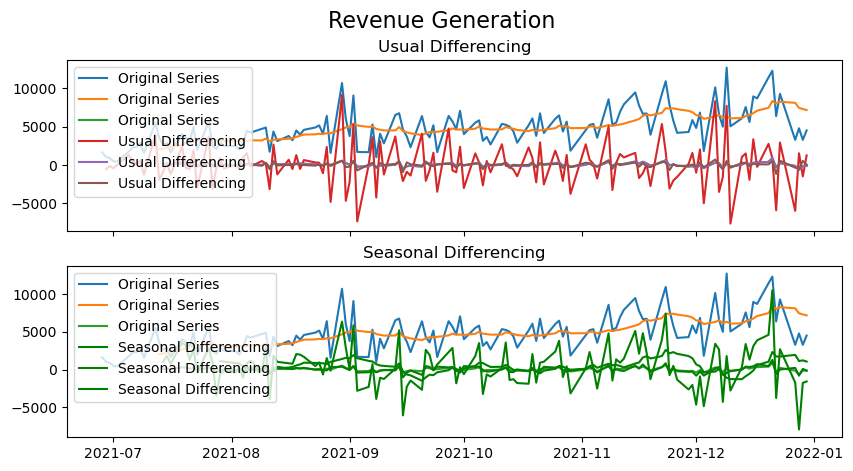

In [62]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df_revenue[:], label='Original Series')
axes[0].plot(df_revenue[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(df_revenue[:], label='Original Series')
axes[1].plot(df_revenue[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Revenue Generation', fontsize=16)
plt.show()

After seasonal differencing, the spikes seem to be flattened (vs in case of usual differencing)

In [63]:
# Seasonal - fit stepwise auto-ARIMA (SARIMA)
smodel = pm.auto_arima(df_revenue['revenues_from_appointment'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2247.355, Time=0.25 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2233.278, Time=0.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2249.408, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2248.609, Time=0.24 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2228.020, Time=0.46 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2219.511, Time=0.63 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=2231.229, Time=0.23 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=2221.704, Time=0.58 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=2219.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  132
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -1105.755
Date:                  Fri, 10 Jun 2022   AIC                           2219.511
Time:                          11:09:55   BIC                           2230.661
Sample:                               0   HQIC                          2224.039
                                  - 132                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    839.8036    260.199      3.228      0.001     329.822    1349.785
ar.S.L12      -0.5608      0.083     -6.745      0.000      -0.724      -0.398
ar.S.L24      -0.3364      0.094     -3.598      0.000      -0.520      -0.153
sigma2      5.468e+06    6.4e+05      8.550      0.000    4.21e+06    6.72e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 4.03
Prob(Q):                              0.60   Prob(JB):                         0.13
Heteroskedasticity (H):               2.07   Skew:                             0.36
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

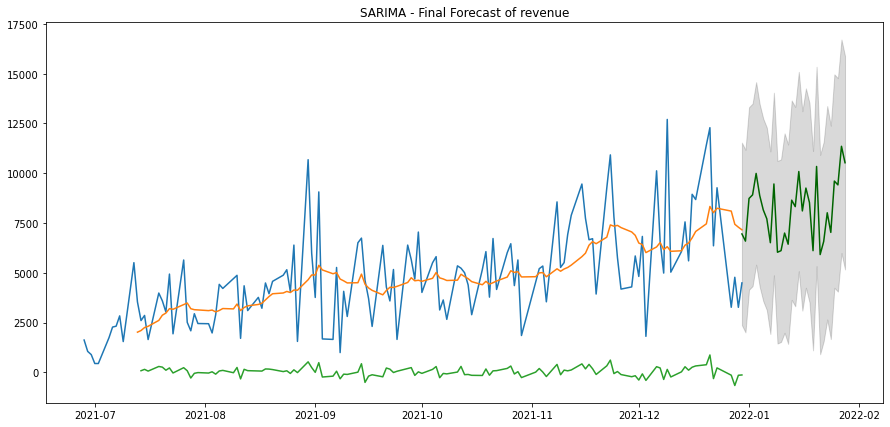

In [64]:
# Model Prediction
n_periods = 30
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_revenue.index[-1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,7))
plt.plot(df_revenue)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of revenue")
plt.show()

In [65]:
print(fitted_series)

2021-12-30     6949.865739
2021-12-31     6589.428838
2022-01-01     8730.459074
2022-01-02     8912.126716
2022-01-03     9987.667937
2022-01-04     8880.781709
2022-01-05     8158.226018
2022-01-06     7710.308904
2022-01-07     6509.192209
2022-01-08     9458.721165
2022-01-09     6030.223317
2022-01-10     6109.492864
2022-01-11     6993.369421
2022-01-12     6433.103535
2022-01-13     8646.038641
2022-01-14     8320.766030
2022-01-15    10083.542756
2022-01-16     8104.659976
2022-01-17     9252.541806
2022-01-18     8520.353702
2022-01-19     6108.926424
2022-01-20    10337.620859
2022-01-21     5913.390813
2022-01-22     6571.405103
2022-01-23     8012.137263
2022-01-24     7027.173211
2022-01-25     9603.639942
2022-01-26     9413.041953
2022-01-27    11350.022327
2022-01-28    10525.144774
Freq: D, dtype: float64


In [66]:
type(fitted_series)

pandas.core.series.Series

In [67]:
df_forecasted_values = fitted_series.to_frame()

In [59]:
print(df_forecasted_values)

                       0
2021-12-30   6949.865739
2021-12-31   6589.428838
2022-01-01   8730.459074
2022-01-02   8912.126716
2022-01-03   9987.667937
2022-01-04   8880.781709
2022-01-05   8158.226018
2022-01-06   7710.308904
2022-01-07   6509.192209
2022-01-08   9458.721165
2022-01-09   6030.223317
2022-01-10   6109.492864
2022-01-11   6993.369421
2022-01-12   6433.103535
2022-01-13   8646.038641
2022-01-14   8320.766030
2022-01-15  10083.542756
2022-01-16   8104.659976
2022-01-17   9252.541806
2022-01-18   8520.353702
2022-01-19   6108.926424
2022-01-20  10337.620859
2022-01-21   5913.390813
2022-01-22   6571.405103
2022-01-23   8012.137263
2022-01-24   7027.173211
2022-01-25   9603.639942
2022-01-26   9413.041953
2022-01-27  11350.022327
2022-01-28  10525.144774


In [69]:
df_forecasted_values.columns = ['forecasted revenues']
df_forecasted_values.head()

,forecasted revenues
2021-12-30,6949.865739
2021-12-31,6589.428838
2022-01-01,8730.459074
2022-01-02,8912.126716
2022-01-03,9987.667937


In [72]:
# converting data frame to csv
df_forecasted_values.to_csv("Forecasted_values.csv", header=True, index=True)

In [47]:
type(df_revenue)

pandas.core.frame.DataFrame

In [73]:
rms_sarima = np.sqrt(mean_squared_error(df_revenue['revenues_from_appointment'][-30:], fitted_series))
print("Root Mean Squared Error: ", rms_sarima)

Root Mean Squared Error:  3754.9963025044303


In [74]:
# Calculating the mean absolute error
mae_sarima = mean_absolute_error(df_revenue['revenues_from_appointment'][-30:], fitted_series)
print("Mean Absolute Error: ", mae_sarima)

Mean Absolute Error:  3208.957524732933


Model 3: Seasonal ARIMAX (SARIMAX)

In [75]:
#adding exogenous variable
df_revenue['month_index'] = df_revenue.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df_revenue[['revenues_from_appointment']], exogenous=df_revenue[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2247.995, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2233.921, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2250.974, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2251.755, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2220.982, Time=1.02 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2219.407, Time=0.56 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=2229.103, Time=0.28 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=2221.275, Time=0.68 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=2221.1

In [76]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  132
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -1105.702
Date:                  Fri, 10 Jun 2022   AIC                           2219.404
Time:                          11:14:04   BIC                           2230.554
Sample:                               0   HQIC                          2223.932
                                  - 132                                         
Covariance Type:                    opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_index   651.0470    199.252      3.267      0.001     260.521    1041.573
ar.S.L12       -0.6248      0.094     -6.669      0.000      -0.808      -0.441
ar.S.L24       -0.3354      0.108     -3.093      0.002      -0.548      -0.123
sigma2       6.335e+06   8.13e+05      7.795      0.000    4.74e+06    7.93e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 8.97
Prob(Q):                              0.76   Prob(JB):                         0.01
Heteroskedasticity (H):               2.10   Skew:                             0.57
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

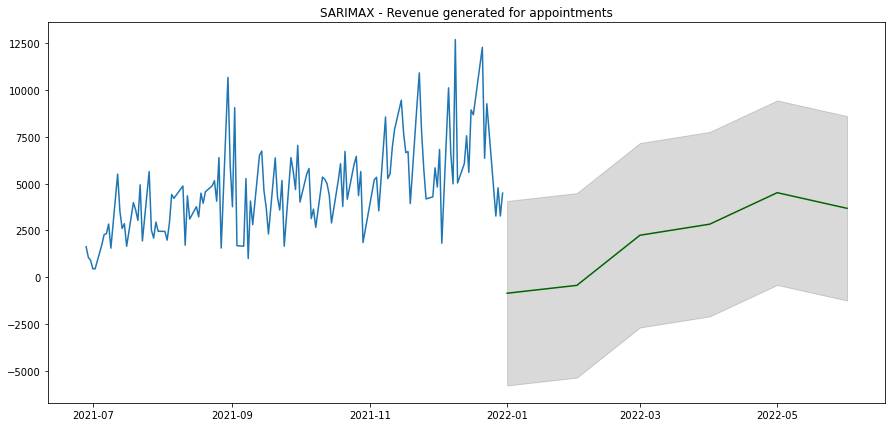

In [77]:
def sarimax_forecast(SARIMAX_model, periods=6):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df_revenue.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df_revenue.index[-1], periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df_revenue.index[-1], periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_revenue["revenues_from_appointment"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Revenue generated for appointments")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=6)

The graph above does not provide us with a good forecast value and there are certain negative values too and moreover there is no upward trend as the previous graph.

In [78]:
rms_sarimax = np.sqrt(mean_squared_error(df_revenue['revenues_from_appointment'][-30:], fitted_series))
print("Root Mean Squared Error: ", rms_sarimax)

Root Mean Squared Error:  3754.9963025044303


In [79]:
# Calculating the mean absolute error
mae_sarimax = mean_absolute_error(df_revenue['revenues_from_appointment'][-30:], fitted_series)
print("Mean Absolute Error: ", mae_sarimax)

Mean Absolute Error:  3208.957524732933


The models used above performs somewhat well like the SARIMA model and it gives us acceptable results
according to the graph, thus we can consider the forecasted values of SARIMA model

SARIMAX gives negative results somewhere whereas the ARIMA modeling does not trend well with the training data and gives results not relevant as such.

I have referenced from the articles and resources below which helped me a lot in solving the problem

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
https://builtin.com/data-science/time-series-forecasting-python
https://medium.com/analytics-vidhya/predicting-sales-time-series-analysis-forecasting-with-python-b81d3e8ff03f
https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d    

0